# Vorhersage eines Triebwerksausfalls aufgrund von Sensormesswerten

In [1]:
import h5py
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '../data/N-CMAPSS_DS03-012.h5'

In [3]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        A_var = list(np.array(A_var, dtype='U20'))

In [16]:
df_A = DataFrame(data=A_dev, columns=A_var)
df_A_test = DataFrame(data=A_test, columns=A_var)
df_A.describe()


,unit,cycle,Fc,hs
count,5.571277e+06,5.571277e+06,5.571277e+06,5.571277e+06
mean,5.382994e+00,3.637726e+01,2.170105e+00,3.319295e-01
std,2.399958e+00,2.157529e+01,7.257075e-01,4.709059e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,1.800000e+01,2.000000e+00,0.000000e+00
50%,6.000000e+00,3.600000e+01,2.000000e+00,0.000000e+00
75%,8.000000e+00,5.400000e+01,3.000000e+00,1.000000e+00
max,9.000000e+00,9.300000e+01,3.000000e+00,1.000000e+00


### Unit Ids 
Mit diesem Codeabschnitt wird geschaut wie viele Triebwerke im Devset und im Testset sind.

In [17]:
print(np.unique(df_A["unit"]))
print(np.unique(df_A_test["unit"]))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[10. 11. 12. 13. 14. 15.]


## Datenaufbereitung

In [4]:
# Train
cycle = A_dev[:, 1].reshape(-1, 1)
fc = A_dev[:, 0].reshape(-1, 1)
X_train = np.concatenate((cycle, fc), axis=1)
Y_train = Y_dev.ravel()

# Test
cycle_test = A_test[:, 1].reshape(-1, 1)
fc_test = A_test[:, 0].reshape(-1, 1)
X_test = np.concatenate((cycle_test, fc_test), axis=1)
Y_test = Y_test.ravel()

## XGBoost

In [5]:
# Import
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

In [6]:
feature_names = (["cycle", "fc"])
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=Y_test, feature_names=feature_names)

### Model Training

In [ ]:
# Training parameters
params = {
    "objective": "reg:squarederror",   # regression
    "max_depth": 5,                    # tree depth
    "eta": 0.05,                       # learning rate
    "subsample": 0.8,                  # row sampling
    "colsample_bytree": 0.8,           # feature
    "gamma": 0.1,                      # require improvement to split 
    "tree_method": "hist",             # use GPU for training
    "device": "cuda",                  # use GPU
    "seed": 42
}

# Train model
num_round = 600
evallist = [(dtrain, "train"), (dtest, "eval")]

bst = xgb.train(
    params, 
    dtrain, 
    num_round, 
    evals=evallist, 
    early_stopping_rounds=20,  # stop if no improvement
    verbose_eval=10            # print progress every 10 rounds
)

bst.save_model("../models/xgb_rul_onlycycle.json")

[0]	train-rmse:20.61029	eval-rmse:20.42010
[10]	train-rmse:15.32469	eval-rmse:15.63162
[20]	train-rmse:12.35717	eval-rmse:13.65211
[30]	train-rmse:10.01106	eval-rmse:12.57236
[40]	train-rmse:7.95960	eval-rmse:11.90311
[50]	train-rmse:6.66289	eval-rmse:12.15170
[59]	train-rmse:5.43430	eval-rmse:12.13180


### Vorhersage  
In dem folgenden Codeabschnitt wird zunächst das gespeicherte Modell geladen. Anschliessend wird für alle Datenpunkte im Testset das RUL vorhergesagt.

In [7]:
# Load the model
model = xgb.Booster()
model.load_model("../models/xgb_rul_onlycycle.json")

In [8]:
# Predict
Y_pred = model.predict(dtest)

In [17]:
feature_names = (["cycle", "fc"])
new_sensor_value = xgb.DMatrix([[ 45, 3 ]], feature_names=feature_names) # insert new cycle and fc values

rul_pred = model.predict(new_sensor_value)
print("Predicted RUL:", rul_pred[0])

Predicted RUL: 25.45365


### Evaluation

In [18]:
rmse = root_mean_squared_error(Y_test, Y_pred)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 12.10


Die Feature Importances zeigen an, welches Feature für das Modell am wichtigsten für die Vorhersage des RUL ist.

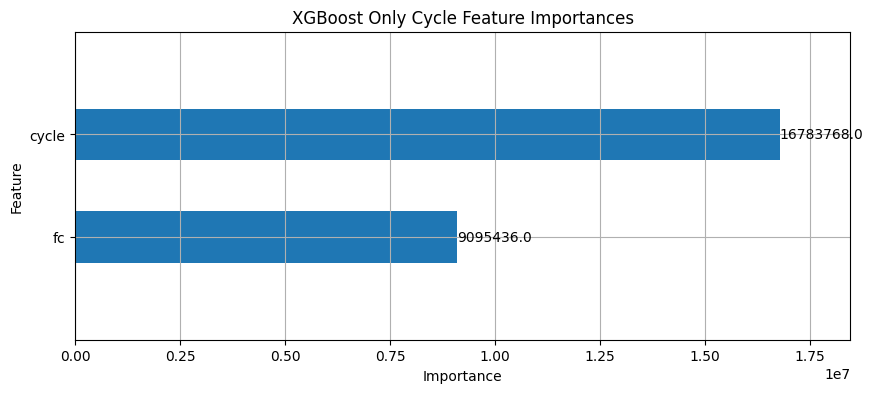

In [19]:
# Feature importances
fig, ax = plt.subplots(figsize=(10, 4))
xgb.plot_importance(model, importance_type="gain", height=0.5, ax=ax)
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")
ax.set_title("XGBoost Only Cycle Feature Importances")
plt.show()

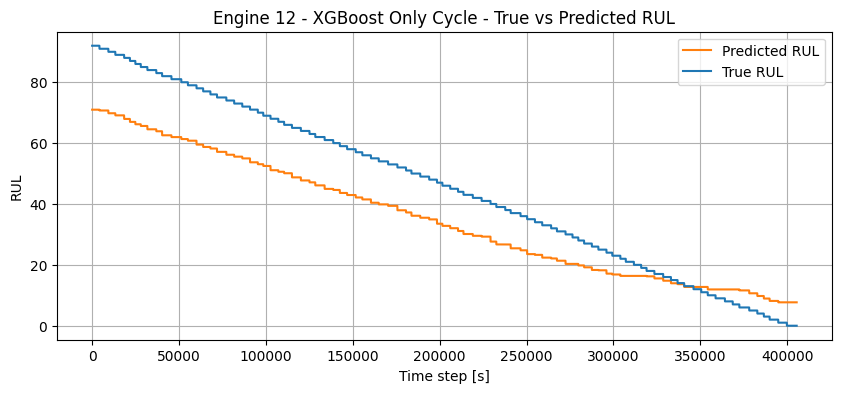

In [20]:
unit_ids_test = A_test[:, 0]
unit = 12
indices = np.where(unit_ids_test == unit)[0]

plt.figure(figsize=(10, 4))
plt.plot(Y_pred[indices], label="Predicted RUL", color='tab:orange')
plt.plot(Y_test[indices], label="True RUL", color='tab:blue')
plt.title(f"Engine {unit} - XGBoost Only Cycle - True vs Predicted RUL")
plt.xlabel("Time step [s]")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()